In [1]:
import pandas as pd
import pytorch_lightning as pl
import numpy as np
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary
from math import floor

from scipy.signal import periodogram

from deepant import AnomalyDetector, DataModule, TrafficDataset, DeepAnt

from utils import plot_predictions, loss_plot, ts_plot

pl.seed_everything(42, workers=True)

from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay, classification_report
import matplotlib.pyplot as plt

if not torch.cuda.is_available():
    print('Please Activate GPU Accelerator if available')
else:
    print('Everything is Set')


/Users/Okano700/Documents/GitHub/DeepAnt/deepAntEnv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


Please Activate GPU Accelerator if available


UCR_120_ECG2 15000 [16000, 16100]


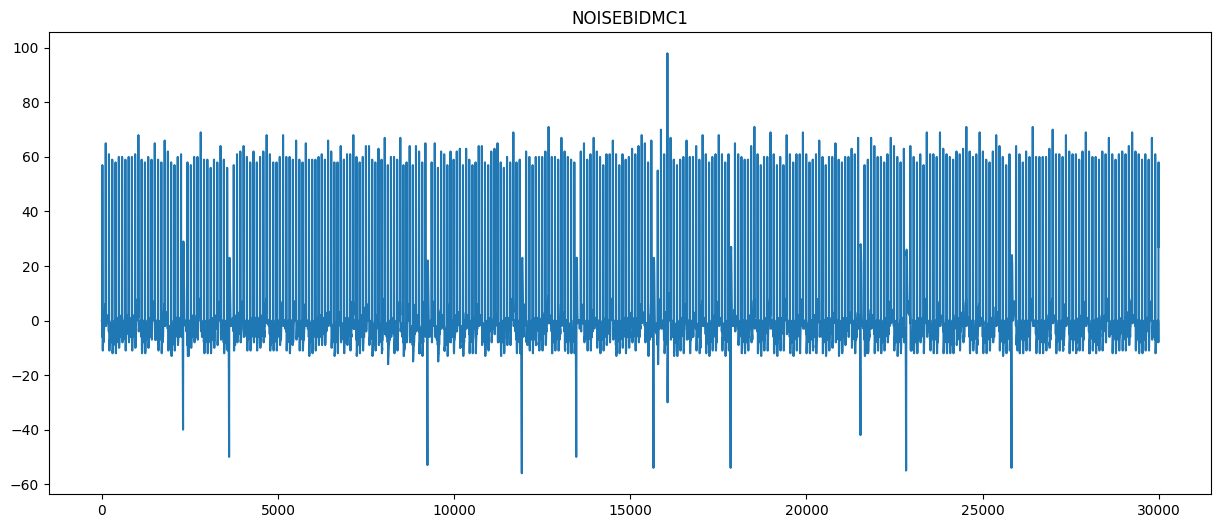

In [2]:
#df = pd.read_csv('data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
path = '/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/120_UCR_Anomaly_ECG2_15000_16000_16100.txt'


split_name = str(path).split('/')[-1]
split_name = str(split_name).split('.')[0]
name_aux = str(split_name).split('_')
ds_name = f"{name_aux[1]}_{name_aux[0]}_{name_aux[3]}"
m_v = int(name_aux[4])
an = [int(name_aux[5]), int(name_aux[6])]
print(ds_name, m_v, an)
#self.df = pd.read_csv(path, header = None)
#self.ts = np.genfromtxt(path)
#self.df = pd.DataFrame(self.ts)
#self._features['DS_name'] = self.ds_name



df_1 = np.genfromtxt(path)
df = pd.DataFrame(df_1,columns=['value'])
df.plot(figsize = (15, 6), title = 'NOISEBIDMC1', legend = False);
y_ = np.zeros(len(df))
y_[an[0]:an[1]] =1
df['anomaly'] = y_
#plt.plot()

In [3]:
f, px = periodogram(np.array(df)[:,0], detrend='linear')
floor(1/f[np.argmax(px)] + 0.5)
n = 20
ind = np.argpartition(px, -n)[-n:]


print([floor(1/f[a] + 0.5) for a in px.argsort()[-n:][::-1]])
print([f[a] for a in px.argsort()[-n:][::-1]])

[94, 94, 93, 91, 92, 91, 92, 46, 91, 31, 90, 93, 46, 47, 89, 89, 23, 92, 30, 23]
[0.010666666666666668, 0.010633333333333333, 0.010766666666666667, 0.011000000000000001, 0.0109, 0.010966666666666668, 0.010833333333333334, 0.021733333333333334, 0.010933333333333333, 0.03216666666666667, 0.011166666666666667, 0.010700000000000001, 0.0219, 0.0213, 0.0112, 0.011233333333333333, 0.0429, 0.010866666666666667, 0.0329, 0.04293333333333334]


In [4]:
#treinamento

In [ ]:
res = []
for l in [25, 50, 75, 94, 2*94, 4* 94, 8* 94]:
    SEQ_LEN = 94*l
    dataset = TrafficDataset(df, SEQ_LEN)
    target_idx = dataset.timestamp # Timestamps to detect where the Anomaly Happens
    #X, y = dataset[0]
    #X.shape, y.shape, len(dataset) # Checking Sizes are compatible...


    model = DeepAnt(SEQ_LEN, 1)
    anomaly_detector = AnomalyDetector(model)
    dm = DataModule(df, SEQ_LEN)
    mc = ModelCheckpoint(
        dirpath = f'DeepAnt-ckp_{l*94}', #mudar
        save_last = True,
        save_top_k = 1,
        verbose = True,
        monitor = 'train_loss', 
        mode = 'min'
        )

    mc.CHECKPOINT_NAME_LAST = f'DeepAnt-ckp' #mudar
    #summary(model)

    trainer = pl.Trainer(max_epochs=30,
                        accelerator="auto",
                        #devices=1, 
                        callbacks=[mc], 
                        #progress_bar_refresh_rate=30, 
                        #fast_dev_run=True,
                        #overfit_batches=1
                        )
    trainer.fit(anomaly_detector, dm)

    anomaly_detector = AnomalyDetector.load_from_checkpoint(f'DeepAnt-ckp_{l*94}/DeepAnt-ckp.ckpt',model = model)

    output = trainer.predict(anomaly_detector, dm)
    preds_losses = pd.Series(torch.tensor([item[1] for item in output]).numpy(), index = target_idx)
    fpr, tpr, thresholds = roc_curve(df['anomaly'].iloc[m_v:], preds_losses.loc[m_v:])
    res_auc = auc(fpr,tpr)
    res.append({'run':f'{ds_name}_{l}','auc':res_auc})
    pd.DataFrame(res).to_csv(f'{ds_name}_bmk.csv', index = False)
    print(f'{ds_name}_bmk.csv --> AUC', flush=True)
    aux = []
    for tr in np.arange(0.1,1,0.1):
        resf = classification_report(df['anomaly'].iloc[m_v:],[1 if it> tr else 0 for it in preds_losses.loc[m_v:] ],output_dict= True, target_names = ['normal','anomaly'])
        aux.append({'threshold': tr,
                  'precision':resf['anomaly']['precision'],
                  'recall':resf['anomaly']['recall'],
                  'f1-score':resf['anomaly']['precision'],
                  'acc':resf['accuracy']})

    pd.DataFrame(aux).to_csv(f'{ds_name}_{l*94}_fscore.csv', index = False)
    print(f'{ds_name}_{l*94}_fscore.csv --> resultados f1-score', flush=True)
    del trainer
    del anomaly_detector
    del model
    del dataset
    del dm
    
    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params
--------------------------------------
0 | model     | DeepAnt | 753 K 
1 | criterion | L1Loss  | 0     
--------------------------------------
753 K     Trainable params
0         Non-trainable params
753 K     Total params
3.014     Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:07<00:00, 12.91it/s, loss=0.0629, v_num=23, train_loss=0.0704]

Epoch 0, global step 865: 'train_loss' reached 0.07038 (best 0.07038), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_2350/epoch=0-step=865.ckpt' as top 1


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:20<00:00, 10.73it/s, loss=0.0657, v_num=23, train_loss=0.0295]

Epoch 1, global step 1730: 'train_loss' reached 0.02955 (best 0.02955), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_2350/epoch=1-step=1730.ckpt' as top 1


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:20<00:00, 10.74it/s, loss=0.0615, v_num=23, train_loss=0.0401]

Epoch 2, global step 2595: 'train_loss' was not in top 1


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:18<00:00, 10.98it/s, loss=0.0562, v_num=23, train_loss=0.0508]

Epoch 3, global step 3460: 'train_loss' was not in top 1


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:20<00:00, 10.79it/s, loss=0.063, v_num=23, train_loss=0.050]

Epoch 4, global step 4325: 'train_loss' was not in top 1


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:18<00:00, 10.97it/s, loss=0.0593, v_num=23, train_loss=0.0135]

Epoch 5, global step 5190: 'train_loss' reached 0.01347 (best 0.01347), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_2350/epoch=5-step=5190.ckpt' as top 1


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:18<00:00, 11.03it/s, loss=0.0662, v_num=23, train_loss=0.138]

Epoch 6, global step 6055: 'train_loss' was not in top 1


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:18<00:00, 10.96it/s, loss=0.0604, v_num=23, train_loss=0.0546]

Epoch 7, global step 6920: 'train_loss' was not in top 1


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:18<00:00, 10.98it/s, loss=0.055, v_num=23, train_loss=0.0455]

Epoch 8, global step 7785: 'train_loss' was not in top 1


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:20<00:00, 10.73it/s, loss=0.0512, v_num=23, train_loss=0.0274]

Epoch 9, global step 8650: 'train_loss' was not in top 1


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:19<00:00, 10.81it/s, loss=0.0548, v_num=23, train_loss=0.0566]

Epoch 10, global step 9515: 'train_loss' was not in top 1


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:19<00:00, 10.82it/s, loss=0.0503, v_num=23, train_loss=0.0672]

Epoch 11, global step 10380: 'train_loss' was not in top 1


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:20<00:00, 10.78it/s, loss=0.0547, v_num=23, train_loss=0.0211]

Epoch 12, global step 11245: 'train_loss' was not in top 1


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:20<00:00, 10.75it/s, loss=0.0547, v_num=23, train_loss=0.111]

Epoch 13, global step 12110: 'train_loss' was not in top 1


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.67it/s, loss=0.0593, v_num=23, train_loss=0.145]

Epoch 14, global step 12975: 'train_loss' was not in top 1


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.63it/s, loss=0.0511, v_num=23, train_loss=0.0693]

Epoch 15, global step 13840: 'train_loss' was not in top 1


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:20<00:00, 10.72it/s, loss=0.0565, v_num=23, train_loss=0.179]

Epoch 16, global step 14705: 'train_loss' was not in top 1


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.67it/s, loss=0.0477, v_num=23, train_loss=0.0421]

Epoch 17, global step 15570: 'train_loss' was not in top 1


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.56it/s, loss=0.0462, v_num=23, train_loss=0.0301]

Epoch 18, global step 16435: 'train_loss' was not in top 1


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.63it/s, loss=0.0535, v_num=23, train_loss=0.116]

Epoch 19, global step 17300: 'train_loss' was not in top 1


Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:22<00:00, 10.52it/s, loss=0.05, v_num=23, train_loss=0.0615]

Epoch 20, global step 18165: 'train_loss' was not in top 1


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.67it/s, loss=0.0472, v_num=23, train_loss=0.0498]

Epoch 21, global step 19030: 'train_loss' was not in top 1


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.62it/s, loss=0.0465, v_num=23, train_loss=0.0876]

Epoch 22, global step 19895: 'train_loss' was not in top 1


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.59it/s, loss=0.0438, v_num=23, train_loss=0.0096]

Epoch 23, global step 20760: 'train_loss' reached 0.00960 (best 0.00960), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_2350/epoch=23-step=20760.ckpt' as top 1


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:24<00:00, 10.28it/s, loss=0.0445, v_num=23, train_loss=0.0494]

Epoch 24, global step 21625: 'train_loss' was not in top 1


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:22<00:00, 10.47it/s, loss=0.0375, v_num=23, train_loss=0.0164]

Epoch 25, global step 22490: 'train_loss' was not in top 1


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.61it/s, loss=0.0403, v_num=23, train_loss=0.0336]

Epoch 26, global step 23355: 'train_loss' was not in top 1


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:24<00:00, 10.24it/s, loss=0.0479, v_num=23, train_loss=0.151]

Epoch 27, global step 24220: 'train_loss' was not in top 1


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.60it/s, loss=0.042, v_num=23, train_loss=0.00393]

Epoch 28, global step 25085: 'train_loss' reached 0.00393 (best 0.00393), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_2350/epoch=28-step=25085.ckpt' as top 1


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [01:21<00:00, 10.58it/s, loss=0.0411, v_num=23, train_loss=0.0289]

Epoch 29, global step 25950: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27650/27650 [02:19<00:00, 197.59it/s]
UCR_120_ECG2_bmk.csv --> AUC
UCR_120_ECG2_2350_fscore.csv --> resultados f1-score


/Users/Okano700/Documents/GitHub/DeepAnt/deepAntEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Okano700/Documents/GitHub/DeepAnt/deepAntEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Okano700/Documents/GitHub/DeepAnt/deepAntEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:47<00:00,  7.33it/s, loss=0.075, v_num=24, train_loss=0.0807]

Epoch 0, global step 791: 'train_loss' reached 0.08070 (best 0.08070), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_4700/epoch=0-step=791.ckpt' as top 1


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:57<00:00,  6.73it/s, loss=0.0728, v_num=24, train_loss=0.0921]

Epoch 1, global step 1582: 'train_loss' was not in top 1


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:54<00:00,  6.91it/s, loss=0.0688, v_num=24, train_loss=0.0792]

Epoch 2, global step 2373: 'train_loss' reached 0.07917 (best 0.07917), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_4700/epoch=2-step=2373.ckpt' as top 1


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:57<00:00,  6.71it/s, loss=0.0662, v_num=24, train_loss=0.0603]

Epoch 3, global step 3164: 'train_loss' reached 0.06030 (best 0.06030), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_4700/epoch=3-step=3164.ckpt' as top 1


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.79it/s, loss=0.0725, v_num=24, train_loss=0.0544]

Epoch 4, global step 3955: 'train_loss' reached 0.05440 (best 0.05440), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_4700/epoch=4-step=3955.ckpt' as top 1


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.80it/s, loss=0.0672, v_num=24, train_loss=0.048]

Epoch 5, global step 4746: 'train_loss' reached 0.04795 (best 0.04795), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_4700/epoch=5-step=4746.ckpt' as top 1


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:58<00:00,  6.70it/s, loss=0.0692, v_num=24, train_loss=0.0677]

Epoch 6, global step 5537: 'train_loss' was not in top 1


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:57<00:00,  6.73it/s, loss=0.0711, v_num=24, train_loss=0.0352]

Epoch 7, global step 6328: 'train_loss' reached 0.03520 (best 0.03520), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_4700/epoch=7-step=6328.ckpt' as top 1


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.78it/s, loss=0.0637, v_num=24, train_loss=0.0588]

Epoch 8, global step 7119: 'train_loss' was not in top 1


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:55<00:00,  6.83it/s, loss=0.0641, v_num=24, train_loss=0.0603]

Epoch 9, global step 7910: 'train_loss' was not in top 1


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.81it/s, loss=0.0622, v_num=24, train_loss=0.0587]

Epoch 10, global step 8701: 'train_loss' was not in top 1


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:58<00:00,  6.67it/s, loss=0.0614, v_num=24, train_loss=0.0506]

Epoch 11, global step 9492: 'train_loss' was not in top 1


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.82it/s, loss=0.061, v_num=24, train_loss=0.0737]

Epoch 12, global step 10283: 'train_loss' was not in top 1


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.77it/s, loss=0.0606, v_num=24, train_loss=0.0516]

Epoch 13, global step 11074: 'train_loss' was not in top 1


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:58<00:00,  6.69it/s, loss=0.0614, v_num=24, train_loss=0.053]

Epoch 14, global step 11865: 'train_loss' was not in top 1


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.78it/s, loss=0.0622, v_num=24, train_loss=0.0634]

Epoch 15, global step 12656: 'train_loss' was not in top 1


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:58<00:00,  6.69it/s, loss=0.0581, v_num=24, train_loss=0.0561]

Epoch 16, global step 13447: 'train_loss' was not in top 1


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:57<00:00,  6.73it/s, loss=0.0598, v_num=24, train_loss=0.0711]

Epoch 17, global step 14238: 'train_loss' was not in top 1


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.77it/s, loss=0.0574, v_num=24, train_loss=0.0518]

Epoch 18, global step 15029: 'train_loss' was not in top 1


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:58<00:00,  6.67it/s, loss=0.058, v_num=24, train_loss=0.0534]

Epoch 19, global step 15820: 'train_loss' was not in top 1


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:59<00:00,  6.64it/s, loss=0.0603, v_num=24, train_loss=0.0451]

Epoch 20, global step 16611: 'train_loss' was not in top 1


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:58<00:00,  6.69it/s, loss=0.0561, v_num=24, train_loss=0.0521]

Epoch 21, global step 17402: 'train_loss' was not in top 1


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:58<00:00,  6.66it/s, loss=0.0568, v_num=24, train_loss=0.0671]

Epoch 22, global step 18193: 'train_loss' was not in top 1


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:57<00:00,  6.73it/s, loss=0.0561, v_num=24, train_loss=0.0556]

Epoch 23, global step 18984: 'train_loss' was not in top 1


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:57<00:00,  6.73it/s, loss=0.0576, v_num=24, train_loss=0.073]

Epoch 24, global step 19775: 'train_loss' was not in top 1


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.81it/s, loss=0.0607, v_num=24, train_loss=0.0676]

Epoch 25, global step 20566: 'train_loss' was not in top 1


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:55<00:00,  6.83it/s, loss=0.0558, v_num=24, train_loss=0.0575]

Epoch 26, global step 21357: 'train_loss' was not in top 1


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:56<00:00,  6.80it/s, loss=0.052, v_num=24, train_loss=0.0476]

Epoch 27, global step 22148: 'train_loss' was not in top 1


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:57<00:00,  6.75it/s, loss=0.0538, v_num=24, train_loss=0.0462]

Epoch 28, global step 22939: 'train_loss' was not in top 1


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [01:57<00:00,  6.72it/s, loss=0.0499, v_num=24, train_loss=0.0434]

Epoch 29, global step 23730: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:16<00:00,  5.24it/s, loss=0.0547, v_num=25, train_loss=0.0547]

Epoch 0, global step 718: 'train_loss' reached 0.05472 (best 0.05472), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_7050/epoch=0-step=718.ckpt' as top 1


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:19<00:00,  5.15it/s, loss=0.062, v_num=25, train_loss=0.105]

Epoch 1, global step 1436: 'train_loss' was not in top 1


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:16<00:00,  5.26it/s, loss=0.0486, v_num=25, train_loss=0.0448]

Epoch 2, global step 2154: 'train_loss' reached 0.04479 (best 0.04479), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_7050/epoch=2-step=2154.ckpt' as top 1


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:17<00:00,  5.21it/s, loss=0.0506, v_num=25, train_loss=0.0187]

Epoch 3, global step 2872: 'train_loss' reached 0.01874 (best 0.01874), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_7050/epoch=3-step=2872.ckpt' as top 1


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:17<00:00,  5.21it/s, loss=0.0532, v_num=25, train_loss=0.0715]

Epoch 4, global step 3590: 'train_loss' was not in top 1


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:17<00:00,  5.20it/s, loss=0.0491, v_num=25, train_loss=0.0274]

Epoch 5, global step 4308: 'train_loss' was not in top 1


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:19<00:00,  5.16it/s, loss=0.051, v_num=25, train_loss=0.0384]

Epoch 6, global step 5026: 'train_loss' was not in top 1


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:19<00:00,  5.14it/s, loss=0.0521, v_num=25, train_loss=0.141]

Epoch 7, global step 5744: 'train_loss' was not in top 1


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.09it/s, loss=0.044, v_num=25, train_loss=0.0224]

Epoch 8, global step 6462: 'train_loss' was not in top 1


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:18<00:00,  5.17it/s, loss=0.048, v_num=25, train_loss=0.0581]

Epoch 9, global step 7180: 'train_loss' was not in top 1


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:19<00:00,  5.14it/s, loss=0.043, v_num=25, train_loss=0.0217]

Epoch 10, global step 7898: 'train_loss' was not in top 1


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:19<00:00,  5.14it/s, loss=0.0435, v_num=25, train_loss=0.0258]

Epoch 11, global step 8616: 'train_loss' was not in top 1


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:21<00:00,  5.09it/s, loss=0.0419, v_num=25, train_loss=0.0489]

Epoch 12, global step 9334: 'train_loss' was not in top 1


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.12it/s, loss=0.0413, v_num=25, train_loss=0.0354]

Epoch 13, global step 10052: 'train_loss' was not in top 1


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:23<00:00,  4.99it/s, loss=0.0397, v_num=25, train_loss=0.0298]

Epoch 14, global step 10770: 'train_loss' was not in top 1


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:21<00:00,  5.07it/s, loss=0.0413, v_num=25, train_loss=0.0321]

Epoch 15, global step 11488: 'train_loss' was not in top 1


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.11it/s, loss=0.0402, v_num=25, train_loss=0.0329]

Epoch 16, global step 12206: 'train_loss' was not in top 1


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.10it/s, loss=0.0417, v_num=25, train_loss=0.0423]

Epoch 17, global step 12924: 'train_loss' was not in top 1


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:21<00:00,  5.06it/s, loss=0.0403, v_num=25, train_loss=0.0525]

Epoch 18, global step 13642: 'train_loss' was not in top 1


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:25<00:00,  4.92it/s, loss=0.0373, v_num=25, train_loss=0.0385]

Epoch 19, global step 14360: 'train_loss' was not in top 1


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.10it/s, loss=0.0359, v_num=25, train_loss=0.0188]

Epoch 20, global step 15078: 'train_loss' was not in top 1


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.12it/s, loss=0.0412, v_num=25, train_loss=0.0563]

Epoch 21, global step 15796: 'train_loss' was not in top 1


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:22<00:00,  5.03it/s, loss=0.0368, v_num=25, train_loss=0.0266]

Epoch 22, global step 16514: 'train_loss' was not in top 1


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:22<00:00,  5.04it/s, loss=0.0368, v_num=25, train_loss=0.0309]

Epoch 23, global step 17232: 'train_loss' was not in top 1


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.10it/s, loss=0.0308, v_num=25, train_loss=0.0414]

Epoch 24, global step 17950: 'train_loss' was not in top 1


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.12it/s, loss=0.0337, v_num=25, train_loss=0.041]

Epoch 25, global step 18668: 'train_loss' was not in top 1


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.12it/s, loss=0.0346, v_num=25, train_loss=0.0187]

Epoch 26, global step 19386: 'train_loss' reached 0.01866 (best 0.01866), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_7050/epoch=26-step=19386.ckpt' as top 1


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:20<00:00,  5.11it/s, loss=0.0314, v_num=25, train_loss=0.0269]

Epoch 27, global step 20104: 'train_loss' was not in top 1


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:22<00:00,  5.06it/s, loss=0.0332, v_num=25, train_loss=0.0259]

Epoch 28, global step 20822: 'train_loss' was not in top 1


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [02:22<00:00,  5.05it/s, loss=0.0294, v_num=25, train_loss=0.0182]

Epoch 29, global step 21540: 'train_loss' reached 0.01822 (best 0.01822), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_7050/epoch=29-step=21540.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22950/22950 [02:14<00:00, 170.03it/s]
UCR_120_ECG2_bmk.csv --> AUC
UCR_120_ECG2_7050_fscore.csv --> resultados f1-score


/Users/Okano700/Documents/GitHub/DeepAnt/deepAntEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Okano700/Documents/GitHub/DeepAnt/deepAntEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Okano700/Documents/GitHub/DeepAnt/deepAntEnv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:26<00:00,  4.52it/s, loss=0.0799, v_num=26, train_loss=0.0532]

Epoch 0, global step 662: 'train_loss' reached 0.05320 (best 0.05320), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_8836/epoch=0-step=662.ckpt' as top 1


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:42<00:00,  4.08it/s, loss=0.0791, v_num=26, train_loss=0.0869]

Epoch 1, global step 1324: 'train_loss' was not in top 1


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:40<00:00,  4.13it/s, loss=0.0779, v_num=26, train_loss=0.0636]

Epoch 2, global step 1986: 'train_loss' was not in top 1


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:34<00:00,  4.29it/s, loss=0.0771, v_num=26, train_loss=0.0938]

Epoch 3, global step 2648: 'train_loss' was not in top 1


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:40<00:00,  4.13it/s, loss=0.0773, v_num=26, train_loss=0.061]

Epoch 4, global step 3310: 'train_loss' was not in top 1


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:37<00:00,  4.21it/s, loss=0.0709, v_num=26, train_loss=0.0692]

Epoch 5, global step 3972: 'train_loss' was not in top 1


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:40<00:00,  4.13it/s, loss=0.0755, v_num=26, train_loss=0.0678]

Epoch 6, global step 4634: 'train_loss' was not in top 1


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:33<00:00,  4.30it/s, loss=0.0784, v_num=26, train_loss=0.0785]

Epoch 7, global step 5296: 'train_loss' was not in top 1


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:40<00:00,  4.12it/s, loss=0.0694, v_num=26, train_loss=0.0595]

Epoch 8, global step 5958: 'train_loss' was not in top 1


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:40<00:00,  4.12it/s, loss=0.0822, v_num=26, train_loss=0.089]

Epoch 9, global step 6620: 'train_loss' was not in top 1


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:39<00:00,  4.15it/s, loss=0.0735, v_num=26, train_loss=0.0484]

Epoch 10, global step 7282: 'train_loss' reached 0.04842 (best 0.04842), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_8836/epoch=10-step=7282.ckpt' as top 1


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:38<00:00,  4.17it/s, loss=0.0695, v_num=26, train_loss=0.0644]

Epoch 11, global step 7944: 'train_loss' was not in top 1


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:40<00:00,  4.12it/s, loss=0.066, v_num=26, train_loss=0.0508]

Epoch 12, global step 8606: 'train_loss' was not in top 1


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:39<00:00,  4.15it/s, loss=0.0671, v_num=26, train_loss=0.0875]

Epoch 13, global step 9268: 'train_loss' was not in top 1


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:38<00:00,  4.18it/s, loss=0.065, v_num=26, train_loss=0.0365]

Epoch 14, global step 9930: 'train_loss' reached 0.03652 (best 0.03652), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_8836/epoch=14-step=9930.ckpt' as top 1


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:39<00:00,  4.15it/s, loss=0.0626, v_num=26, train_loss=0.0553]

Epoch 15, global step 10592: 'train_loss' was not in top 1


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:41<00:00,  4.10it/s, loss=0.0661, v_num=26, train_loss=0.0813]

Epoch 16, global step 11254: 'train_loss' was not in top 1


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:38<00:00,  4.17it/s, loss=0.0664, v_num=26, train_loss=0.0734]

Epoch 17, global step 11916: 'train_loss' was not in top 1


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:39<00:00,  4.16it/s, loss=0.0643, v_num=26, train_loss=0.0478]

Epoch 18, global step 12578: 'train_loss' was not in top 1


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:41<00:00,  4.10it/s, loss=0.0658, v_num=26, train_loss=0.0359]

Epoch 19, global step 13240: 'train_loss' reached 0.03593 (best 0.03593), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_8836/epoch=19-step=13240.ckpt' as top 1


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:39<00:00,  4.15it/s, loss=0.0638, v_num=26, train_loss=0.079]

Epoch 20, global step 13902: 'train_loss' was not in top 1


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:37<00:00,  4.19it/s, loss=0.0607, v_num=26, train_loss=0.058]

Epoch 21, global step 14564: 'train_loss' was not in top 1


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:40<00:00,  4.12it/s, loss=0.0594, v_num=26, train_loss=0.0594]

Epoch 22, global step 15226: 'train_loss' was not in top 1


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:44<00:00,  4.02it/s, loss=0.0607, v_num=26, train_loss=0.0496]

Epoch 23, global step 15888: 'train_loss' was not in top 1


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:39<00:00,  4.15it/s, loss=0.0625, v_num=26, train_loss=0.0621]

Epoch 24, global step 16550: 'train_loss' was not in top 1


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:35<00:00,  4.27it/s, loss=0.0595, v_num=26, train_loss=0.0383]

Epoch 25, global step 17212: 'train_loss' was not in top 1


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:35<00:00,  4.27it/s, loss=0.0592, v_num=26, train_loss=0.0464]

Epoch 26, global step 17874: 'train_loss' was not in top 1


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:37<00:00,  4.21it/s, loss=0.0624, v_num=26, train_loss=0.0457]

Epoch 27, global step 18536: 'train_loss' was not in top 1


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:37<00:00,  4.20it/s, loss=0.0614, v_num=26, train_loss=0.0473]

Epoch 28, global step 19198: 'train_loss' was not in top 1


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [02:40<00:00,  4.13it/s, loss=0.058, v_num=26, train_loss=0.0558]

Epoch 29, global step 19860: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:56<00:00,  2.19it/s, loss=0.0816, v_num=27, train_loss=0.0923]

Epoch 0, global step 386: 'train_loss' reached 0.09229 (best 0.09229), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_17672/epoch=0-step=386.ckpt' as top 1


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:00<00:00,  2.14it/s, loss=0.0787, v_num=27, train_loss=0.0866]

Epoch 1, global step 772: 'train_loss' reached 0.08661 (best 0.08661), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_17672/epoch=1-step=772.ckpt' as top 1


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:59<00:00,  2.15it/s, loss=0.07, v_num=27, train_loss=0.0415]

Epoch 2, global step 1158: 'train_loss' reached 0.04152 (best 0.04152), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_17672/epoch=2-step=1158.ckpt' as top 1


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:04<00:00,  2.09it/s, loss=0.0824, v_num=27, train_loss=0.0981]

Epoch 3, global step 1544: 'train_loss' was not in top 1


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:01<00:00,  2.13it/s, loss=0.0636, v_num=27, train_loss=0.0456]

Epoch 4, global step 1930: 'train_loss' was not in top 1


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:58<00:00,  2.16it/s, loss=0.0693, v_num=27, train_loss=0.0698]

Epoch 5, global step 2316: 'train_loss' was not in top 1


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:58<00:00,  2.16it/s, loss=0.0714, v_num=27, train_loss=0.0555]

Epoch 6, global step 2702: 'train_loss' was not in top 1


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:59<00:00,  2.14it/s, loss=0.0731, v_num=27, train_loss=0.049]

Epoch 7, global step 3088: 'train_loss' was not in top 1


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:01<00:00,  2.13it/s, loss=0.0712, v_num=27, train_loss=0.0478]

Epoch 8, global step 3474: 'train_loss' was not in top 1


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:00<00:00,  2.14it/s, loss=0.0685, v_num=27, train_loss=0.0885]

Epoch 9, global step 3860: 'train_loss' was not in top 1


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:03<00:00,  2.11it/s, loss=0.0678, v_num=27, train_loss=0.0384]

Epoch 10, global step 4246: 'train_loss' reached 0.03836 (best 0.03836), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_17672/epoch=10-step=4246.ckpt' as top 1


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:59<00:00,  2.15it/s, loss=0.0702, v_num=27, train_loss=0.0631]

Epoch 11, global step 4632: 'train_loss' was not in top 1


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:03<00:00,  2.11it/s, loss=0.0701, v_num=27, train_loss=0.0416]

Epoch 12, global step 5018: 'train_loss' was not in top 1


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:05<00:00,  2.09it/s, loss=0.0686, v_num=27, train_loss=0.103]

Epoch 13, global step 5404: 'train_loss' was not in top 1


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:03<00:00,  2.11it/s, loss=0.0647, v_num=27, train_loss=0.0731]

Epoch 14, global step 5790: 'train_loss' was not in top 1


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:58<00:00,  2.16it/s, loss=0.065, v_num=27, train_loss=0.0269]

Epoch 15, global step 6176: 'train_loss' reached 0.02693 (best 0.02693), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/DeepAnt-ckp_17672/epoch=15-step=6176.ckpt' as top 1


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:59<00:00,  2.15it/s, loss=0.0704, v_num=27, train_loss=0.0729]

Epoch 16, global step 6562: 'train_loss' was not in top 1


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:59<00:00,  2.15it/s, loss=0.0638, v_num=27, train_loss=0.057]

Epoch 17, global step 6948: 'train_loss' was not in top 1


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:02<00:00,  2.12it/s, loss=0.0602, v_num=27, train_loss=0.0507]

Epoch 18, global step 7334: 'train_loss' was not in top 1


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:58<00:00,  2.16it/s, loss=0.0627, v_num=27, train_loss=0.066]

Epoch 19, global step 7720: 'train_loss' was not in top 1


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:04<00:00,  2.09it/s, loss=0.0623, v_num=27, train_loss=0.0723]

Epoch 20, global step 8106: 'train_loss' was not in top 1


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:02<00:00,  2.11it/s, loss=0.0667, v_num=27, train_loss=0.0886]

Epoch 21, global step 8492: 'train_loss' was not in top 1


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:04<00:00,  2.10it/s, loss=0.0645, v_num=27, train_loss=0.0738]

Epoch 22, global step 8878: 'train_loss' was not in top 1


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:07<00:00,  2.06it/s, loss=0.0642, v_num=27, train_loss=0.053]

Epoch 23, global step 9264: 'train_loss' was not in top 1


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:03<00:00,  2.10it/s, loss=0.0606, v_num=27, train_loss=0.0629]

Epoch 24, global step 9650: 'train_loss' was not in top 1


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:00<00:00,  2.13it/s, loss=0.0604, v_num=27, train_loss=0.0678]

Epoch 25, global step 10036: 'train_loss' was not in top 1


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:00<00:00,  2.13it/s, loss=0.0584, v_num=27, train_loss=0.0594]

Epoch 26, global step 10422: 'train_loss' was not in top 1


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:02<00:00,  2.12it/s, loss=0.0629, v_num=27, train_loss=0.0635]

Epoch 27, global step 10808: 'train_loss' was not in top 1


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:59<00:00,  2.15it/s, loss=0.0606, v_num=27, train_loss=0.0775]

Epoch 28, global step 11194: 'train_loss' was not in top 1


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [02:58<00:00,  2.16it/s, loss=0.0606, v_num=27, train_loss=0.0342]

Epoch 29, global step 11580: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Predicting DataLoader 0:  40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 4930/12328 [00:32<00:48, 151.30it/s]

In [ ]:
preds_losses = pd.Series(torch.tensor([item[1] for item in output]).numpy(), index = target_idx)

In [8]:
res

[{'run': 'UCR_120_ECG2_25', 'auc': 0.6836090604026845},
 {'run': 'UCR_120_ECG2_50', 'auc': 0.6494412751677853},
 {'run': 'UCR_120_ECG2_75', 'auc': 0.6624721476510067},
 {'run': 'UCR_120_ECG2_94', 'auc': 0.6210214765100672}]

In [ ]:
RocCurveDisplay.from_predictions(df['anomaly'].iloc[preds_losses.index.min():], preds_losses)
#plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#display.plot()

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(df['anomaly'].iloc[m_v:], preds_losses.loc[m_v:])
auc(fpr,tpr)

In [ ]:
aux = []
for tr in np.arange(0.1,1,0.1):
    res = classification_report(df['anomaly'].iloc[m_v:],[1 if it> tr else 0 for it in preds_losses.loc[m_v:] ],output_dict= True, target_names = ['normal','anomaly'])
    aux.append({'threshold': tr,
              'precision':res['anomaly']['precision'],
              'recall':res['anomaly']['recall'],
              'f1-score':res['anomaly']['precision'],
              'acc':res['accuracy']})
    
pd.DataFrame(aux).to_csv(f'{ds_name}_fscore.csv', index = False)

In [ ]:
res = classification_report(df['anomaly'].iloc[m_v:],[1 if it> tr else 0 for it in preds_losses.loc[m_v:] ],output_dict= True, target_names = ['normal','anomaly'])

In [ ]:
tr = 0.5
plt.plot([1 if it> tr else 0 for it in preds_losses.loc[m_v:] ])

In [ ]:
ts_plot(df, preds_losses, 0.5)

In [ ]:
res

In [6]:
aux

[{'threshold': 0.1,
  'precision': 0.0069767441860465115,
  'recall': 0.06,
  'f1-score': 0.0069767441860465115,
  'acc': 0.9368},
 {'threshold': 0.2,
  'precision': 0.023809523809523808,
  'recall': 0.04,
  'f1-score': 0.023809523809523808,
  'acc': 0.9826666666666667},
 {'threshold': 0.30000000000000004,
  'precision': 0.125,
  'recall': 0.02,
  'f1-score': 0.125,
  'acc': 0.9925333333333334},
 {'threshold': 0.4,
  'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'acc': 0.9933333333333333},
 {'threshold': 0.5,
  'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'acc': 0.9933333333333333},
 {'threshold': 0.6,
  'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'acc': 0.9933333333333333},
 {'threshold': 0.7000000000000001,
  'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'acc': 0.9933333333333333},
 {'threshold': 0.8,
  'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'acc': 0.9933333333333333},
 {'threshold': 0.9,
  'precision': 0.0,
  'recall': 0.0,

In [7]:
res

[{'run': 'UCR_120_ECG2_25', 'auc': 0.6836090604026845},
 {'run': 'UCR_120_ECG2_50', 'auc': 0.6494412751677853},
 {'run': 'UCR_120_ECG2_75', 'auc': 0.6624721476510067},
 {'run': 'UCR_120_ECG2_94', 'auc': 0.6210214765100672}]